In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.model.models import DBModel

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_interpolation, plot_decision_boundary


In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
        )
        self.mu = nn.Linear(2, 2)
        self.logvar = nn.Linear(2, 2)
        self.decoder = nn.Sequential(
            torch.nn.Linear(2, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(1024, 33),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [4]:
# Hyperparameters
epochs = 100
kdl_weight=40
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 42

torch.manual_seed(random_seed)

# Model
autoencoder = VAE()
model = DBModel()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../models/autoencoders/vae"
model_path = "{}/model_kdl{}.pth".format(path, kdl_weight)

In [4]:
def loss_fn(x, x_hat, mean, log_var, kdl_weight=40):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kdl_weight*KLD

In [10]:
model.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        reconstructed, mean, logvar = autoencoder(parameters_batch)
        output = model(reconstructed, input)

        # Ground truth
        goal = model(parameters_batch, input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, mean, logvar, kdl_weight)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
    
    print(f"Epoch {epoch} - Loss: {total_loss}")
    if(epoch % 5 == 0):
        torch.save(autoencoder.state_dict(), f"{path}/checkpoint_{epoch}.pth")

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - Loss: 554430658.3125
Epoch 1 - Loss: 470821898.53125
Epoch 2 - Loss: 309216752.625
Epoch 3 - Loss: 278635821.40625
Epoch 4 - Loss: 227537839.8125
Epoch 5 - Loss: 213553966.109375
Epoch 6 - Loss: 241852268.28125
Epoch 7 - Loss: 243928880.515625
Epoch 8 - Loss: 196949280.671875
Epoch 9 - Loss: 197129973.4375
Epoch 10 - Loss: 198487541.71875
Epoch 11 - Loss: 188773298.578125
Epoch 12 - Loss: 174344645.5625
Epoch 13 - Loss: 168391253.96875
Epoch 14 - Loss: 165599920.5625
Epoch 15 - Loss: 164062079.046875
Epoch 16 - Loss: 156026811.28125
Epoch 17 - Loss: 157841944.609375
Epoch 18 - Loss: 154314398.09375
Epoch 19 - Loss: 145955851.953125
Epoch 20 - Loss: 143101334.796875
Epoch 21 - Loss: 143646366.25
Epoch 22 - Loss: 152359645.734375
Epoch 23 - Loss: 139056591.8125
Epoch 24 - Loss: 136949439.46875
Epoch 25 - Loss: 136149955.390625
Epoch 26 - Loss: 136591820.25
Epoch 27 - Loss: 133819096.0
Epoch 28 - Loss: 133953614.109375
Epoch 29 - Loss: 134929924.515625
Epoch 30 - Loss: 132428620

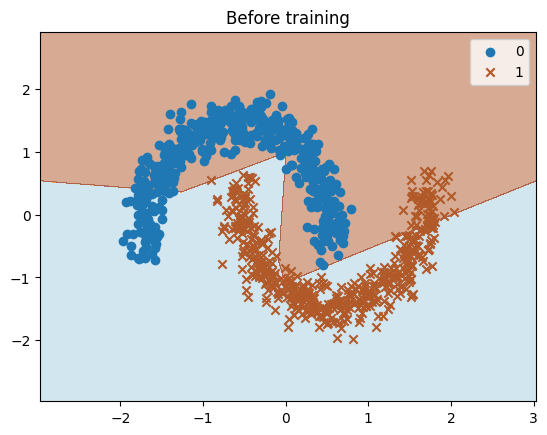

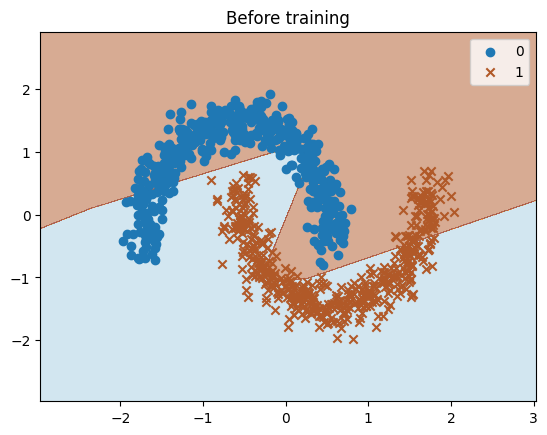

In [106]:
model.eval()
tester.eval()

model.to("cpu")
index = 30000


parameters = dataset[index][0].unsqueeze(0)
X, y = get_moons_dataset()
plot_decision_boundary(tester, parameters, X, y, title="Before training")
plot_decision_boundary(model, parameters, X, y, title="Before training")

## Latent Space

(80000, 2)


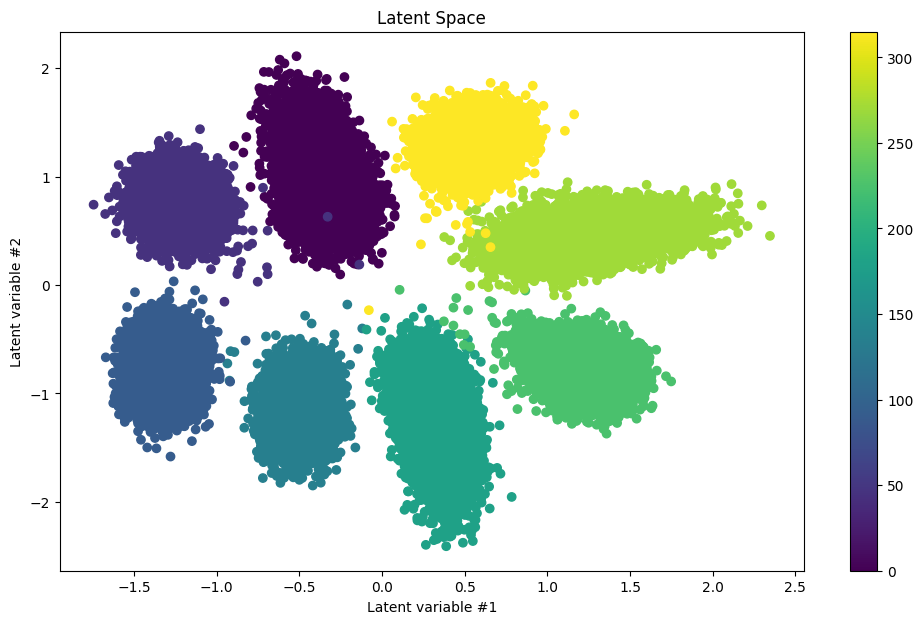

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

model = VAE()
model.load_state_dict(torch.load(model_path))
model.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

weights = torch.tensor(weights).float()
latent, mean, logvar = model(weights)
latent = vae.reparameterize(mean, logvar).detach().numpy()
print(latent.shape)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(latent[:, 0], latent[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.title("Latent Space")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.show()

## Reconstructed weights distribution

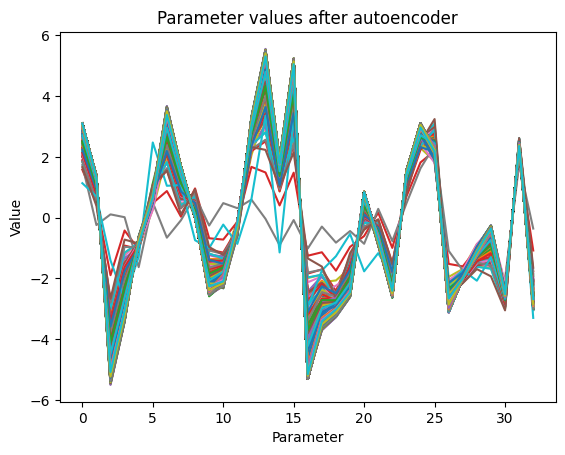

In [17]:
from matplotlib import pyplot as plt

model = VAE()
model.load_state_dict(torch.load(model_path))
model.eval()

reconstruction = []
for i in range(10000, 20000):
    parameters = dataset[i][0].unsqueeze(0)
    r, _, _ = model(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values after autoencoder")
plt.show()

## Accuracy distribution

  0%|          | 0/80000 [00:00<?, ?it/s]

Mean trained accuracy: 99.87490625000002
Mean reconstructed accuracy: 99.85546624999999


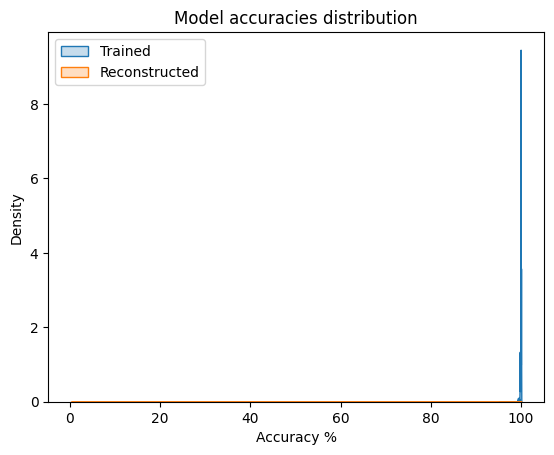

In [6]:
autoencoder = VAE()
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    accuracy = get_accuracy(parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed, _, _ = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    accuracy = get_accuracy(reconstructed, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()


## Interpolation

  0%|          | 0/8 [00:00<?, ?it/s]

Mean interpolation accuracy: 85.35712000000002


Text(0.5, 0, 'Accuracy %')

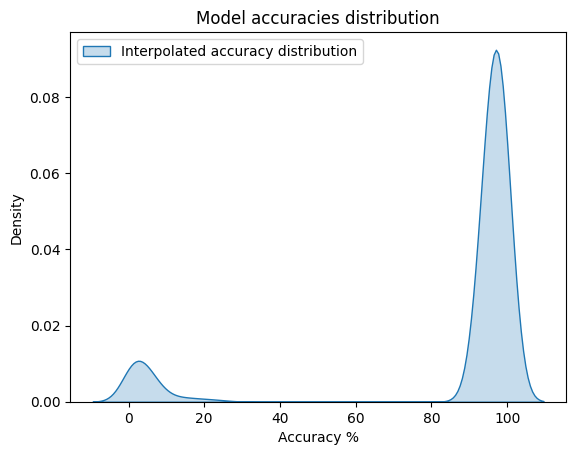

In [9]:
autoencoder = VAE()
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []

for i in tqdm(range(-1, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        mean = autoencoder.mu(latent)
        logvar = autoencoder.logvar(latent)
        latent = autoencoder.reparameterize(mean, logvar)

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
# plt.show()

In [10]:
def plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha):
    parameters_1, angle_1 = datapoint_1
    parameters_2, angle_2 = datapoint_2

    parameters_1 = parameters_1.unsqueeze(0)
    parameters_2 = parameters_2.unsqueeze(0)

    latent_1 = model.encoder(parameters_1)
    latent_2 = model.encoder(parameters_2)

    latent = (1-alpha)*latent_1 + alpha*latent_2

    mean = model.mu(latent)
    logvar = model.logvar(latent)
    latent = model.reparameterize(mean, logvar)
    w = model.decoder(latent).squeeze()

    angle = (1-alpha)*angle_1 + alpha*angle_2
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()

    plot_decision_boundary(w, X_rotated, y)

In [15]:
autoencoder = VAE()
autoencoder.load_state_dict(torch.load("../models/autoencoders/vae/checkpoint_15.pth"))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0.8
index_1 = 100
index_2 = 61000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>